<img align="right" src="https://drive.google.com/uc?id=1-qDugsExSGCUfnJgt4BVUUIeEWC910Uo" width="300"/>  
### **MASTERS IN DATA SCIENCE AND ENGINEERING**  
FCED - Statistics - 1/2021  
Prof. António Miguel Gomes  
Students: Carlos Barth, Daniel Rodrigues, Danilo Brandão  

---

<h1 align="center"> <b>NYPD <i>STOP, QUESTION and FRISK</i> DATA ANALYSIS</b><h1>

# Introduction

The New York City Police department has made data about its *Stop, Question and Frisk* initiative publicly available in CSV format, for the years 2003 through 2020. The program consists in temporarily detaining, questioning, and at times searching civilians and suspects on the street for weapons and other contraband.  
Through the investigation of the available data, information for answering the following question was sought:    

> <h2 align="center"><i>"Are NYPD officers targeting specific types of citizens?</i></h2>



# Data

The original dataset contains 83 columns (variables) and 9544 data entries (lines), as well as many null values. It was sourced directly from the NYC's government webpage and can be found here: https://www1.nyc.gov/site/nypd/stats/reports-analysis/stopfrisk.page.  
Due to scope and time constraints, only the data from the year 2020 was analyzed in this project.  

# Methodology

All the steps taken to analyze the data are going to be described below.  
 
First, the data was imported into a pandas dataframe and then inspected, cleaned and explored. Null values were also addressed in this step.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as stat
import seaborn as sns

In [2]:
rename_columns = {'JURISDICTION_CODE':'LOCATION_JURISDICTION_CODE', 
    'JURISDICTION_DESCRIPTION':'LOCATION_JURISDICTION_DESCRIPTION', 
    'ASK_FOR_CONSENT_FLG':'ASK_FOR_CONSENT_FLAG', 
    'CONSENT_GIVEN_FLG':'CONSENT_GIVEN_FLAG'}
#importing file and formating columns names
stops2020 = pd.read_excel('sqf-2020.xlsx').rename(columns = rename_columns)

#Normaling nulls. Lots of '' instead (null)
stops2020 = stops2020.replace(to_replace='(null)',value='NA')
stops2020 = stops2020.replace(to_replace=np.nan,value='NA')

#find groups patthern
variables_pattherns = ['LOCATION', 'PHYSICAL', 'SUSPECT', 'OFFICER', 'SEARCH', 'FLAG']
agged_variables, columns_to_drop = {}, []
for patthern in variables_pattherns:
    agged_variables[patthern] = stops2020.columns[stops2020.columns.str.contains(patthern)].tolist()
    globals()[f'stops2020_{patthern}'] = stops2020[agged_variables[patthern]]
    columns_to_drop += agged_variables[patthern]
    print(str(f'Criado df: stops2020_{patthern}'))
print(str(f'Criado dict: agged_variables'))
    
# Group day by the shift (night and day)
def day_org(x):
    h, m = x.hour, x.min
    if h >= 6 and h < 22:
        return 'Day'
    else:
        return 'Night'
    
stops2020['DAY_PERIOD'] = stops2020['STOP_FRISK_TIME'].apply(lambda x: day_org(x))

# Round by hour
def day_org(x):
    h, m = x.hour, x.min
    return h
    
stops2020['TIME_HOUR'] = stops2020['STOP_FRISK_TIME'].apply(lambda x: day_org(x))
    
stops20_r_pat = stops2020.drop(columns=columns_to_drop)
#Creating groups of variables 

Criado df: stops2020_LOCATION
Criado df: stops2020_PHYSICAL
Criado df: stops2020_SUSPECT
Criado df: stops2020_OFFICER
Criado df: stops2020_SEARCH
Criado df: stops2020_FLAG
Criado dict: agged_variables


In [3]:
stops2020.head()


STOP_ID STOP_FRISK_DATE STOP_FRISK_TIME STOP_FRISK_TIMESTAMP  YEAR2  \
0        1      2020-01-01        01:12:00  2020-01-01 01:12:00   2020   
1        2      2020-01-01        01:11:00  2020-01-01 01:11:00   2020   
2        3      2020-01-01        01:11:00  2020-01-01 01:11:00   2020   
3        4      2020-01-01        10:18:00  2020-01-01 10:18:00   2020   
4        5      2020-01-01        08:45:00  2020-01-01 08:45:00   2020   

    MONTH2       DAY2  STOP_WAS_INITIATED RECORD_STATUS_CODE  \
0  January  Wednesday  Based on Radio Run                APP   
1  January  Wednesday  Based on Radio Run                APP   
2  January  Wednesday  Based on Radio Run                APP   
3  January  Wednesday  Based on Radio Run                APP   
4  January  Wednesday  Based on Radio Run                APP   

  ISSUING_OFFICER_RANK  ...  STOP_LOCATION_APARTMENT  \
0                  POM  ...                       NA   
1                  POM  ...                       NA   
2                  POM  ...                       NA   
3                  POM  ...                       NA   
4                  POM  ...                       NA   

    STOP_LOCATION_FULL_ADDRESS  STOP_LOCATION_STREET_NAME STOP_LOCATION_X  \
0                  248 E 83 ST                    E 83 ST          997094   
1                  248 E 83 ST                    E 83 ST          997094   
2                  248 E 83 ST                    E 83 ST          997094   
3  LINDEN BLVD && SHEPHERD AVE                LINDEN BLVD         1018441   
4                    481 5 AVE                      5 AVE          987763   

  STOP_LOCATION_Y STOP_LOCATION_ZIP_CODE  STOP_LOCATION_PATROL_BORO_NAME  \
0          222002                  10028                            PBMN   
1          222002                  10028                            PBMN   
2          222002                  10028                            PBMN   
3          181412                  11208                            PBBN   
4          182543                  11215                            PBBS   

  STOP_LOCATION_BORO_NAME  DAY_PERIOD TIME_HOUR  
0               MANHATTAN       Night         1  
1               MANHATTAN       Night         1  
2               MANHATTAN       Night         1  
3                BROOKLYN         Day        10  
4                BROOKLYN         Day         8  

[5 rows x 86 columns]

In [4]:
#Counting all variables by values. If categorical will appear.
def season_org(x):
    winter = ['December', 'January', 'February']
    spring = ['March', 'April', 'May']
    summer = ['June', 'July', 'August']
    autumn = ['September', 'October', 'November']
    if x in winter:
        return 'winter'
    elif x in spring:
        return 'spring'
    elif x in summer:
        return 'summer'
    else:
        return 'autumn'
stops2020['SEASON'] = stops2020['MONTH2'].apply(lambda x: season_org(x))

for col in stops2020.columns:
    tp_data = stops2020[col].value_counts()
    if len(tp_data) <= 2: print(f'Data is Categorical binomial.  Ref {tp_data.name}')
    elif len(tp_data) <= 8: print(f'Data is Categorical (3 to 8 cat) {tp_data.name}')
    else: print(f'Data is Continuous or semi-continous {tp_data.name}')

Data is Continuous or semi-continous STOP_ID
Data is Continuous or semi-continous STOP_FRISK_DATE
Data is Continuous or semi-continous STOP_FRISK_TIME
Data is Continuous or semi-continous STOP_FRISK_TIMESTAMP
Data is Categorical binomial.  Ref YEAR2
Data is Continuous or semi-continous MONTH2
Data is Categorical (3 to 8 cat) DAY2
Data is Categorical (3 to 8 cat) STOP_WAS_INITIATED
Data is Categorical binomial.  Ref RECORD_STATUS_CODE
Data is Continuous or semi-continous ISSUING_OFFICER_RANK
Data is Continuous or semi-continous ISSUING_OFFICER_COMMAND_CODE
Data is Continuous or semi-continous SUPERVISING_OFFICER_RANK
Data is Continuous or semi-continous SUPERVISING_OFFICER_COMMAND_CODE
Data is Categorical (3 to 8 cat) LOCATION_IN_OUT_CODE
Data is Categorical (3 to 8 cat) LOCATION_JURISDICTION_CODE
Data is Categorical (3 to 8 cat) LOCATION_JURISDICTION_DESCRIPTION
Data is Continuous or semi-continous OBSERVED_DURATION_MINUTES
Data is Continuous or semi-continous SUSPECTED_CRIME_DESCRIPTI

# Exploratory Data Analysis
## Stop counts by various categories  

In this step, the variable "number of stops" was tested against other variables by trial and error.  
The goal was to find interesting outcomes that could be meaningful for the analysis.

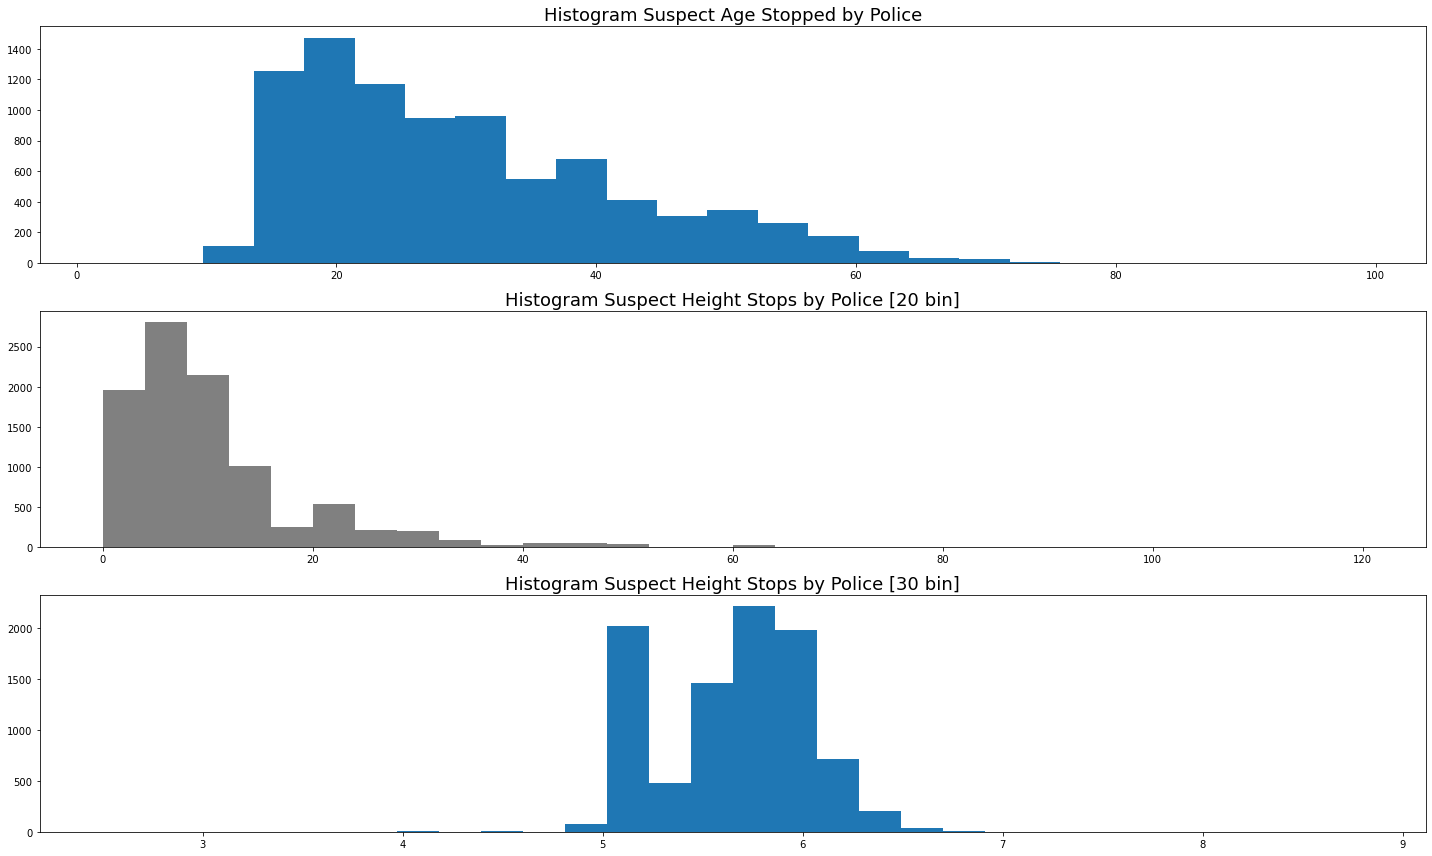

In [5]:
age = stops2020[stops2020['SUSPECT_REPORTED_AGE'] != ' ']
age = age[age['SUSPECT_REPORTED_AGE'] != 0]
height = stops2020[stops2020['SUSPECT_HEIGHT'] != ' ']

fig, axs = plt.subplots(3, figsize=(20,12))
axs[0].hist(age['SUSPECT_REPORTED_AGE'], bins=25)
axs[1].hist(stops2020['STOP_DURATION_MINUTES'], bins=30, color='gray', range=(0, 120))
axs[2].hist(height['SUSPECT_HEIGHT'], bins=30)

axs[0].set_title('Histogram Suspect Age Stopped by Police' , fontsize=18)
axs[1].set_title('Histogram Suspect Height Stops by Police [20 bin]' , fontsize=18)
axs[2].set_title('Histogram Suspect Height Stops by Police [30 bin]' , fontsize=18)

plt.tight_layout()
plt.show()

In [6]:
arrested = stops2020[stops2020[agged_variables['SUSPECT'][1]]=='Y']
ratio_arrested = arrested.count() / stops2020.count()
ratio_arrested[0]

0.37269488683989943

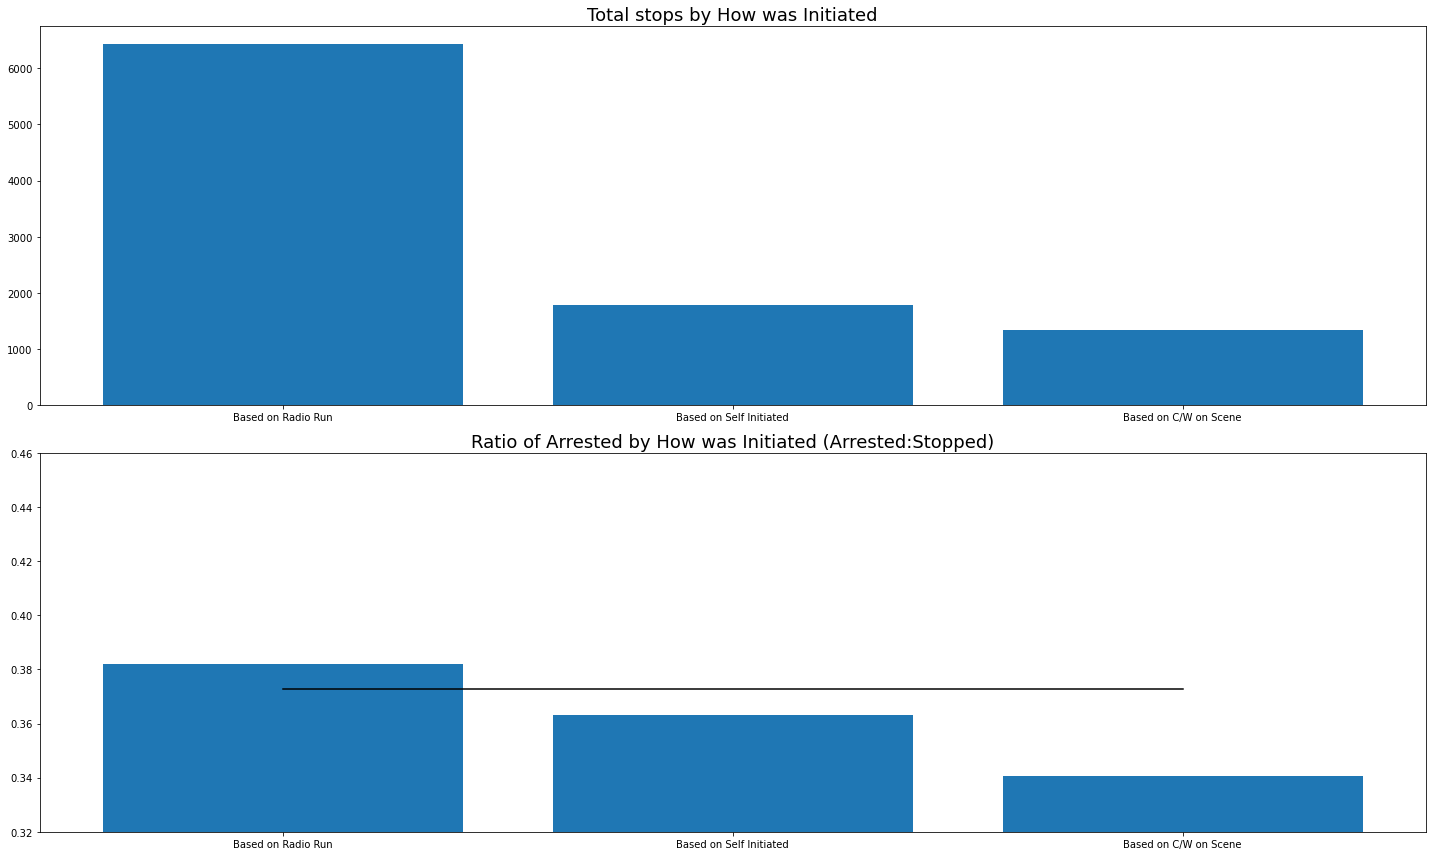

In [7]:
initiaded = stops2020['STOP_WAS_INITIATED'].value_counts()
initiaded_arrested = arrested['STOP_WAS_INITIATED'].value_counts()
initiaded_ratio = initiaded_arrested / initiaded
initiaded_ratio = initiaded_ratio.sort_values(ascending=False)

fig, axs = plt.subplots(2, figsize=(20,12))
axs[0].bar(initiaded.index, height=initiaded)
plt.ylim(0.32,0.46)
axs[1].bar(initiaded_ratio.index, height=initiaded_ratio)
axs[1].plot(initiaded_ratio.index, ratio_arrested[0:len(initiaded_ratio)], color='k')

axs[0].set_title('Total stops by How was Initiated' , fontsize=18)
axs[1].set_title('Ratio of Arrested by How was Initiated (Arrested:Stopped)' , fontsize=18)

plt.tight_layout()
plt.show()

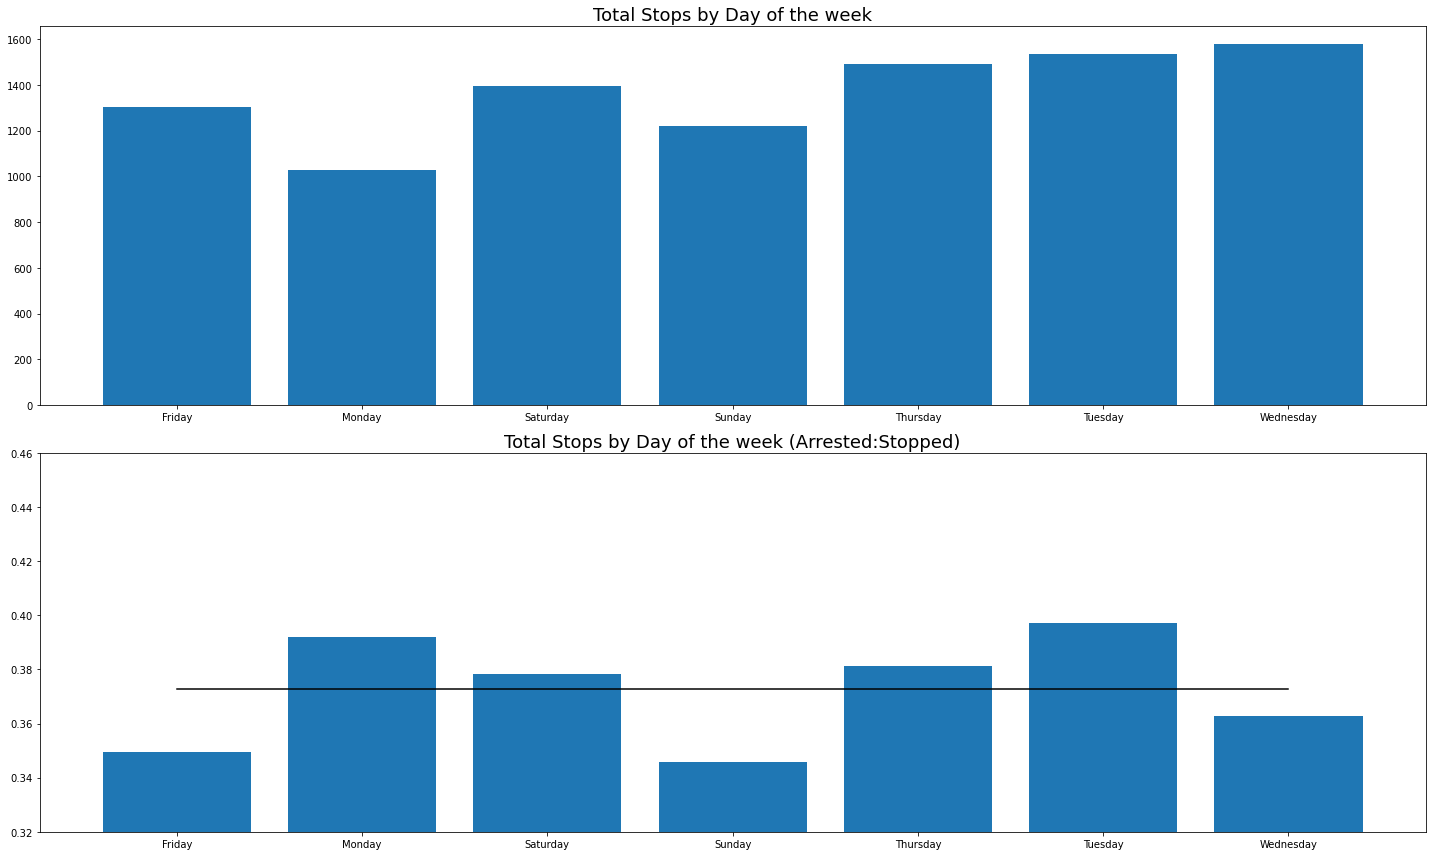

In [8]:
day_week = stops2020['DAY2'].value_counts().sort_index()
day_week_arrested = arrested['DAY2'].value_counts().sort_index()
day_week_ratio = day_week_arrested / day_week

fig, axs = plt.subplots(2, figsize=(20,12))
axs[0].bar(day_week.index, height=day_week)
plt.ylim(0.32,0.46)
axs[1].bar(day_week_ratio.index, height=day_week_ratio)
axs[1].plot(day_week_ratio.index, ratio_arrested[0:len(day_week_ratio)], color='k')

axs[0].set_title('Total Stops by Day of the week' , fontsize=18)
axs[1].set_title('Total Stops by Day of the week (Arrested:Stopped)' , fontsize=18)

plt.tight_layout()
plt.show()

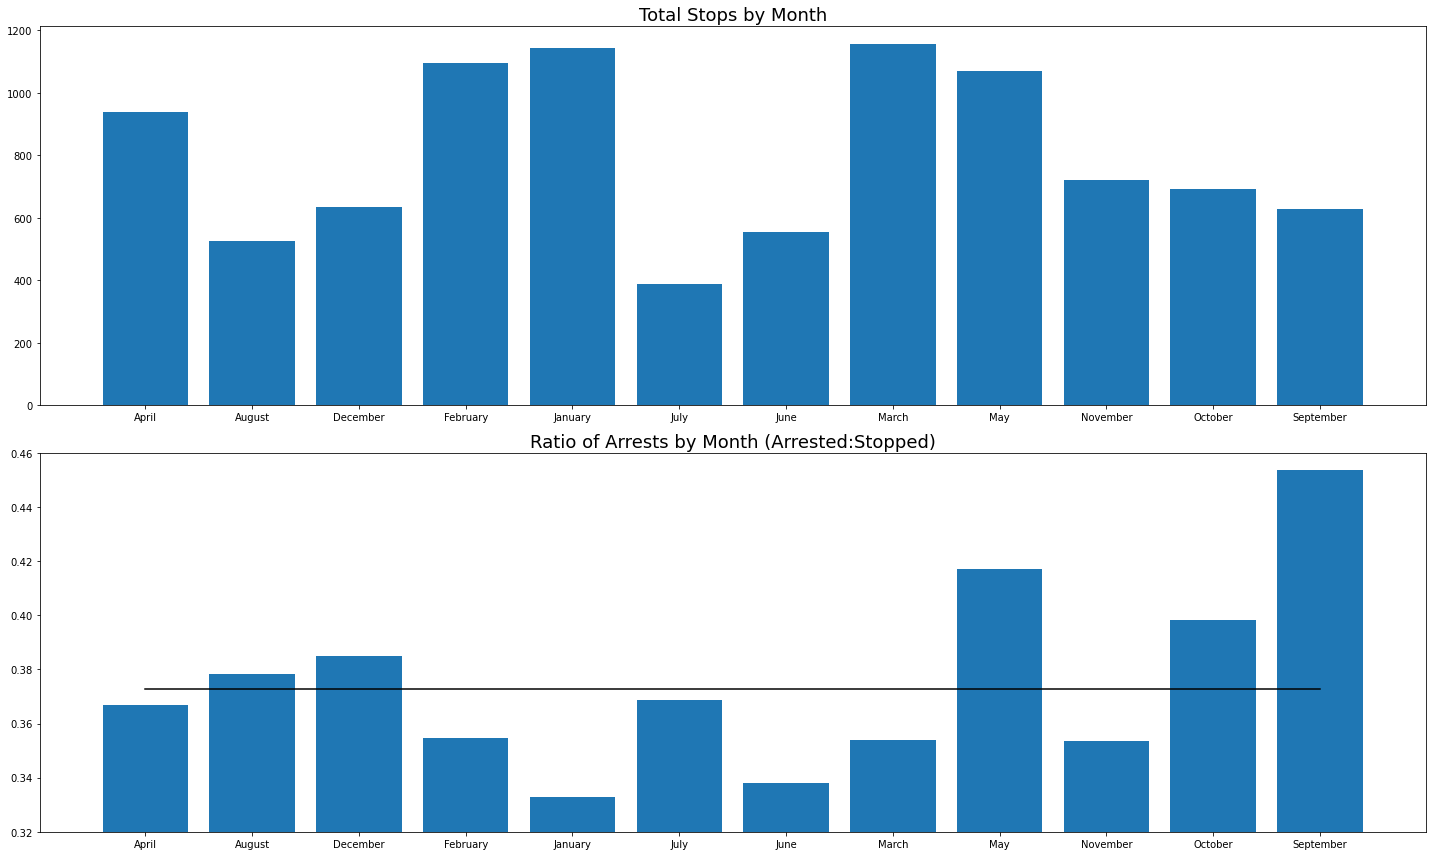

In [9]:
month = stops2020['MONTH2'].value_counts().sort_index()
month_arrested = arrested['MONTH2'].value_counts().sort_index()
month_ratio = month_arrested / month

fig, axs = plt.subplots(2, figsize=(20,12))
axs[0].bar(month.index, height=month)
plt.ylim(0.32,0.46)
axs[1].bar(month_ratio.index, height=month_ratio)
axs[1].plot(month_ratio.index, ratio_arrested[0:len(month_ratio)], color='k')
axs[0].set_title('Total Stops by Month' , fontsize=18)
axs[1].set_title('Ratio of Arrests by Month (Arrested:Stopped)' , fontsize=18)
plt.tight_layout()
plt.show()

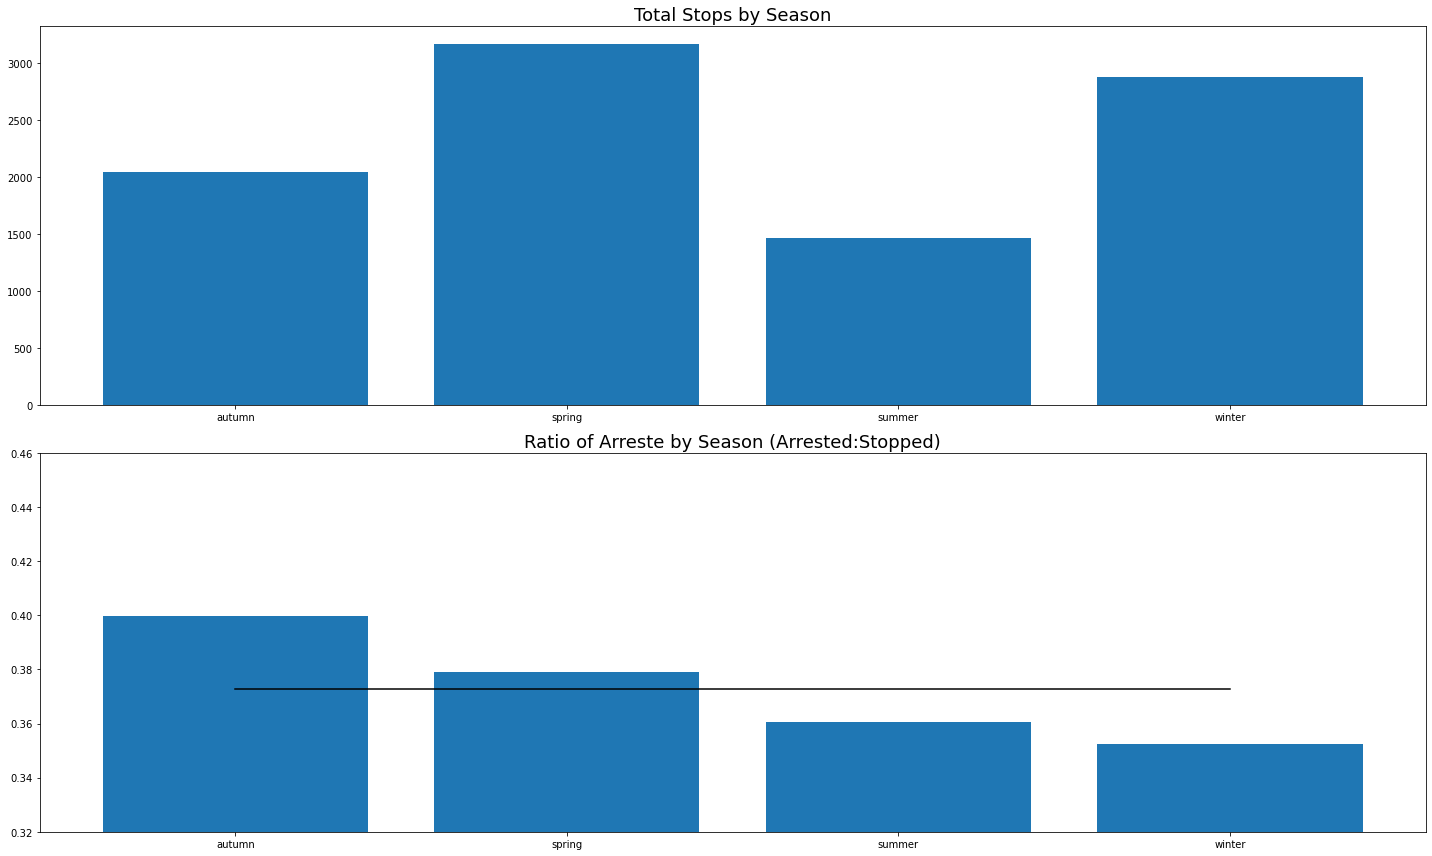

In [10]:
season = stops2020['SEASON'].value_counts().sort_index()
season_arrested = arrested['SEASON'].value_counts().sort_index()
season_ratio = season_arrested / season


fig, axs = plt.subplots(2, figsize=(20,12))
axs[0].bar(season.index ,height=season)
plt.ylim(0.32,0.46)
axs[1].bar(season_ratio.index ,height=season_ratio)
axs[1].plot(season_ratio.index, ratio_arrested[0:len(season_ratio)], color='k')
axs[0].set_title('Total Stops by Season' , fontsize=18)
axs[1].set_title('Ratio of Arreste by Season (Arrested:Stopped)' , fontsize=18)

plt.tight_layout()
plt.show()

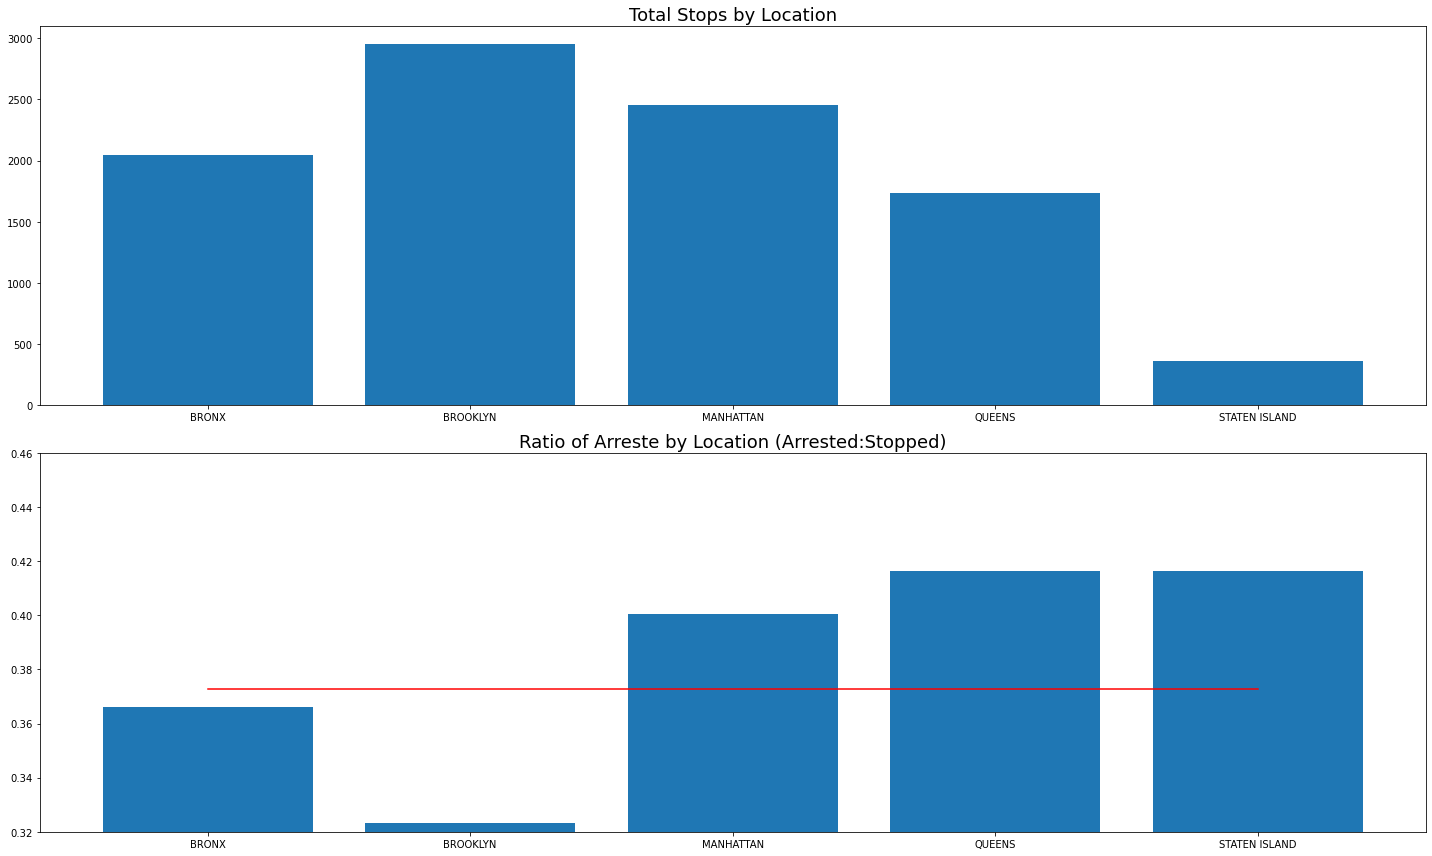

In [11]:
location = stops2020['STOP_LOCATION_BORO_NAME'].value_counts().sort_index()
location_arrested = arrested['STOP_LOCATION_BORO_NAME'].value_counts().sort_index()
location_ratio = location_arrested / location

fig, axs = plt.subplots(2, figsize=(20,12))
axs[0].bar(location.index ,height=location)
plt.ylim(0.32,0.46)
axs[1].bar(location_ratio.index ,height=location_ratio)
axs[1].plot(location_ratio.index, ratio_arrested[0:len(location_ratio)], color='r')
axs[0].set_title('Total Stops by Location' , fontsize=18)
axs[1].set_title('Ratio of Arreste by Location (Arrested:Stopped)' , fontsize=18)
plt.tight_layout()
plt.show()

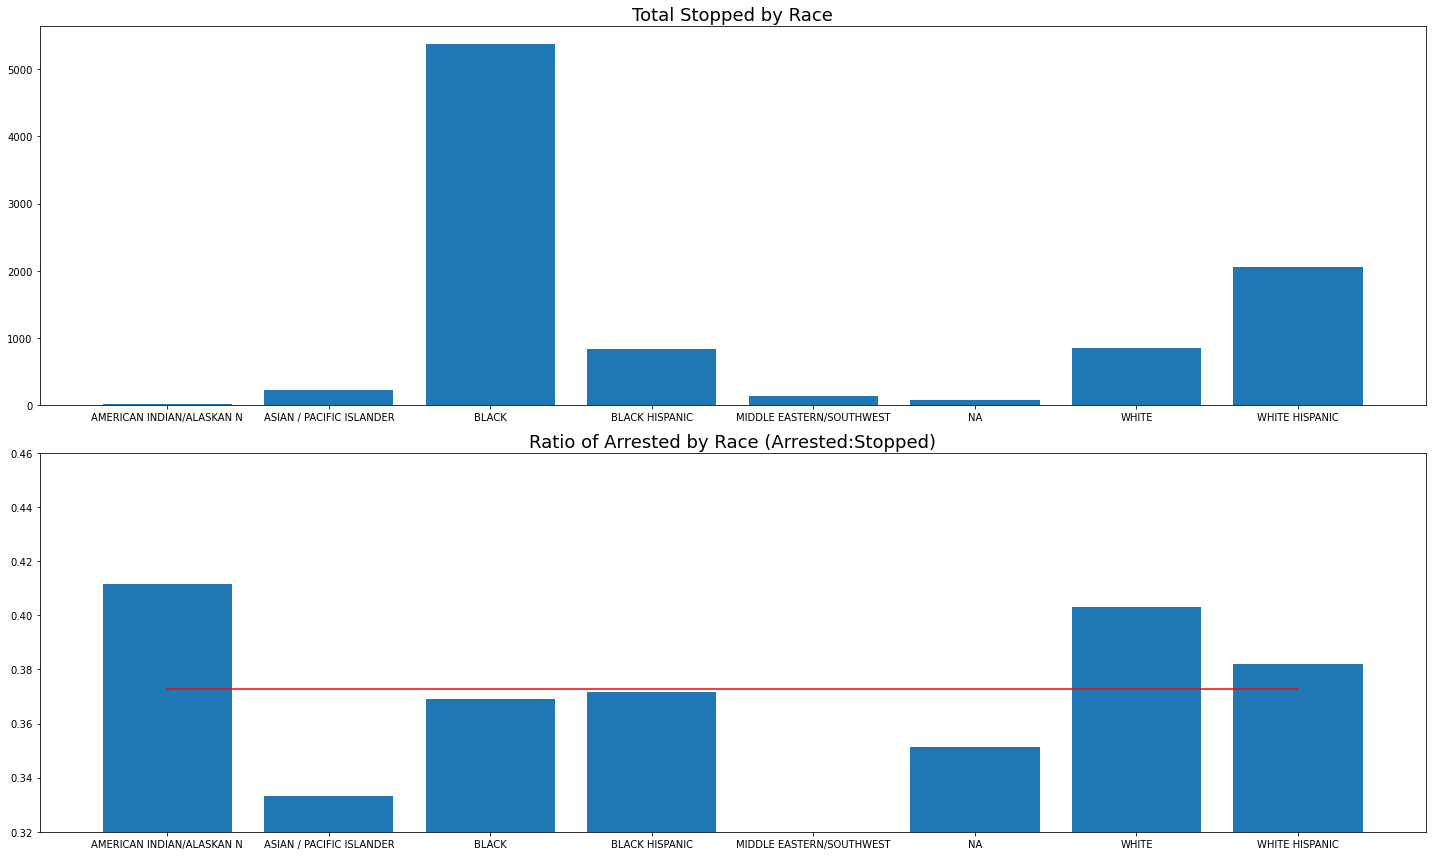

In [12]:
race = stops2020['SUSPECT_RACE_DESCRIPTION'].value_counts().sort_index()
race_arrested = arrested['SUSPECT_RACE_DESCRIPTION'].value_counts().sort_index()
race_ratio = race_arrested / race

fig, axs = plt.subplots(2, figsize=(20,12))
axs[0].bar(race.index ,height=race)
plt.ylim(0.32,0.46)
axs[1].bar(race_ratio.index ,height=race_ratio)
axs[1].plot(race_ratio.index, ratio_arrested[0:len(race_ratio)], color='r')
axs[0].set_title('Total Stopped by Race' , fontsize=18)
axs[1].set_title('Ratio of Arrested by Race (Arrested:Stopped)' , fontsize=18)

plt.tight_layout()
plt.show()

In [13]:
race_ratio

AMERICAN INDIAN/ALASKAN N    0.411765
ASIAN / PACIFIC ISLANDER     0.333333
BLACK                        0.369108
BLACK HISPANIC               0.371532
MIDDLE EASTERN/SOUTHWEST     0.257576
NA                           0.351351
WHITE                        0.403037
WHITE HISPANIC               0.381951
Name: SUSPECT_RACE_DESCRIPTION, dtype: float64

In [14]:
# Renaming variables
race_stopped = stops2020['SUSPECT_RACE_DESCRIPTION'].value_counts().sort_values(ascending=False) #count stopped per race
race_stopped.values
race_stopped_total = race_stopped.values.sum()

race_arrested = arrested['SUSPECT_RACE_DESCRIPTION'].value_counts().sort_values(ascending=False)
race_arrested_total = race_arrested.values.sum()
race_arr_stop_ratio = race_arrested/race_stopped

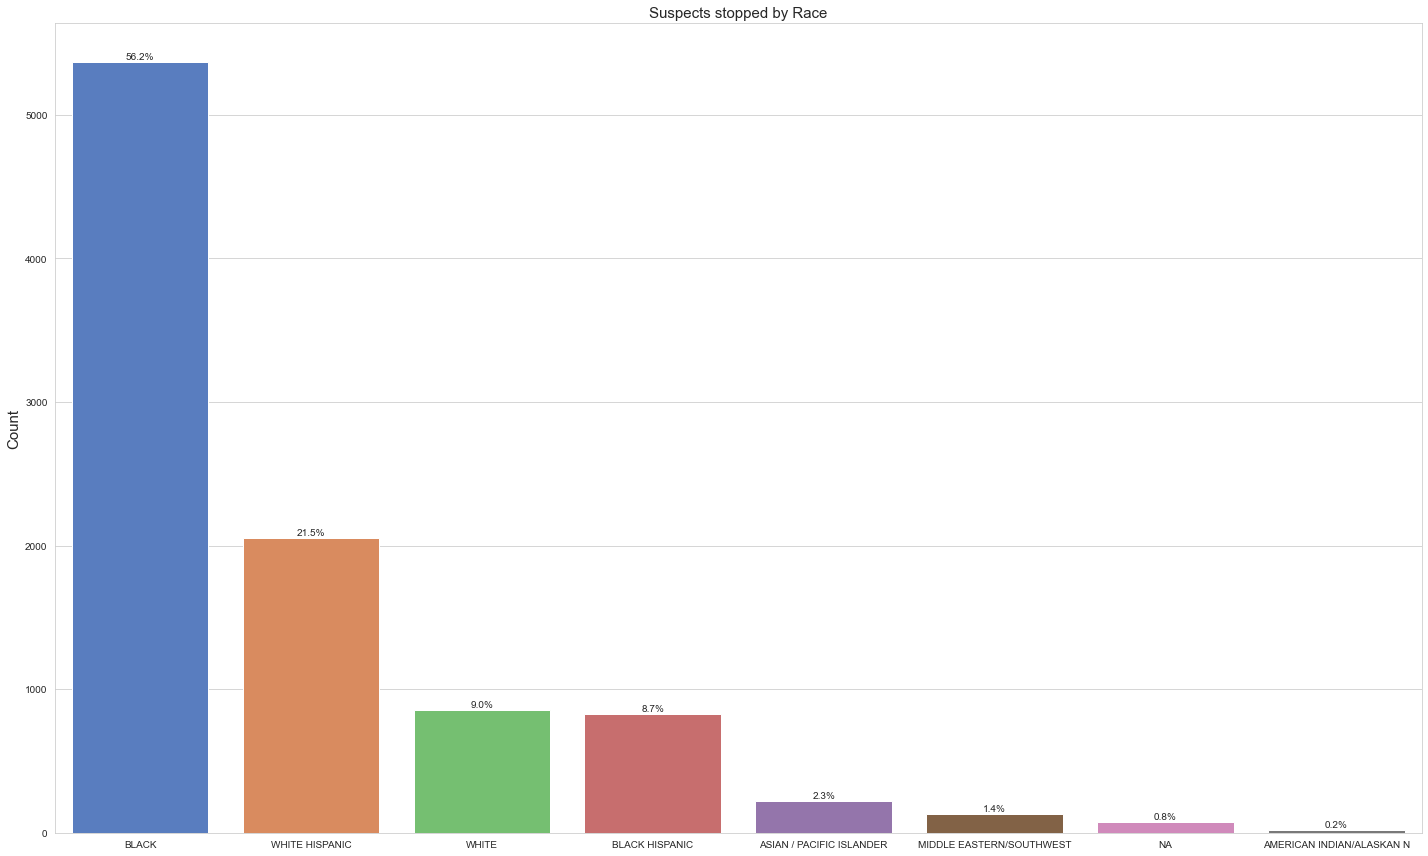

In [15]:
#Ploting total stopped by race wih seaborn
sns.set_style("whitegrid")
bar,axs = plt.subplots(figsize=(20,12))
axs = sns.barplot(x=race_stopped.index, y=race_stopped.values , ci=None, palette="muted",orient='v' )
axs.set_title("Suspects stopped by Race", fontsize=15)
#ax.set_xlabel ("Race", fontsize=15)
axs.set_ylabel ("Count", fontsize=15)
for rect in axs.patches:
  percentage_of_stopped = f'{100 * rect.get_height() / race_stopped_total:.1f}%\n'
  x = rect.get_x() + rect.get_width() / 2
  y = rect.get_height()
  axs.annotate(percentage_of_stopped, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()
  

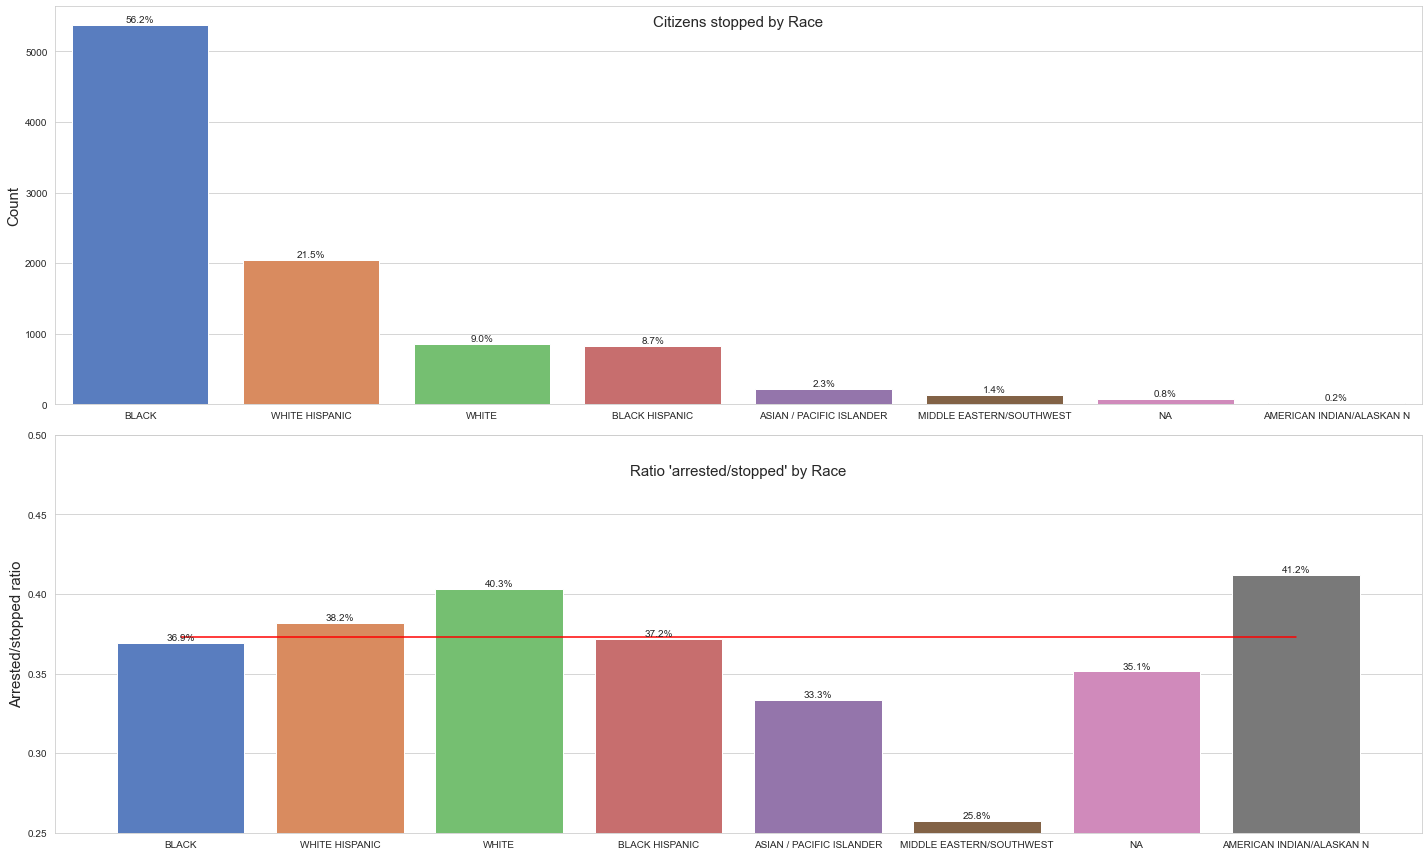

In [16]:
#Ploting total stopped vs arrested/stopped ratio by race wih seaborn
sns.set_style("whitegrid")
bar,axs = plt.subplots(2, 1, figsize=(20,12))
axs[0] = sns.barplot(x=race_stopped.index, y=race_stopped.values , ci=None, palette="muted",orient='v', ax=axs[0])
axs[1] = sns.barplot(x=race_arr_stop_ratio.index, y=race_arr_stop_ratio.values , ci=None, palette="muted",orient='v', ax=axs[1] )
plt.ylim(0.25, 0.5)
axs[1].plot(race_arr_stop_ratio.index, ratio_arrested[0:len(race_ratio)], color='red')

axs[0].set_title("Citizens stopped by Race", fontsize=15, pad=-20)
axs[1].set_title("Ratio 'arrested/stopped' by Race", fontsize=15, pad=-40)

axs[0].set_ylabel ("Count", fontsize=15)
for rect in axs[0].patches:
  percentage_of_stopped = f'{100 * rect.get_height() / race_stopped_total:.1f}%\n'
  x = rect.get_x() + rect.get_width() / 2
  y = rect.get_height()
  axs[0].annotate(percentage_of_stopped, (x, y), ha='center', va='center')

#ax.set_xlabel ("Race", fontsize=15)
axs[1].set_ylabel ("Arrested/stopped ratio", fontsize=15)
for rect in axs[1].patches:
  percentage_of_arrested = f'{100 * rect.get_height() /1 :.1f}%\n'
  x = rect.get_x() + rect.get_width() / 2
  y = rect.get_height()
  axs[1].annotate(percentage_of_arrested, (x, y), ha='center', va='center')
  
plt.tight_layout()
plt.show()

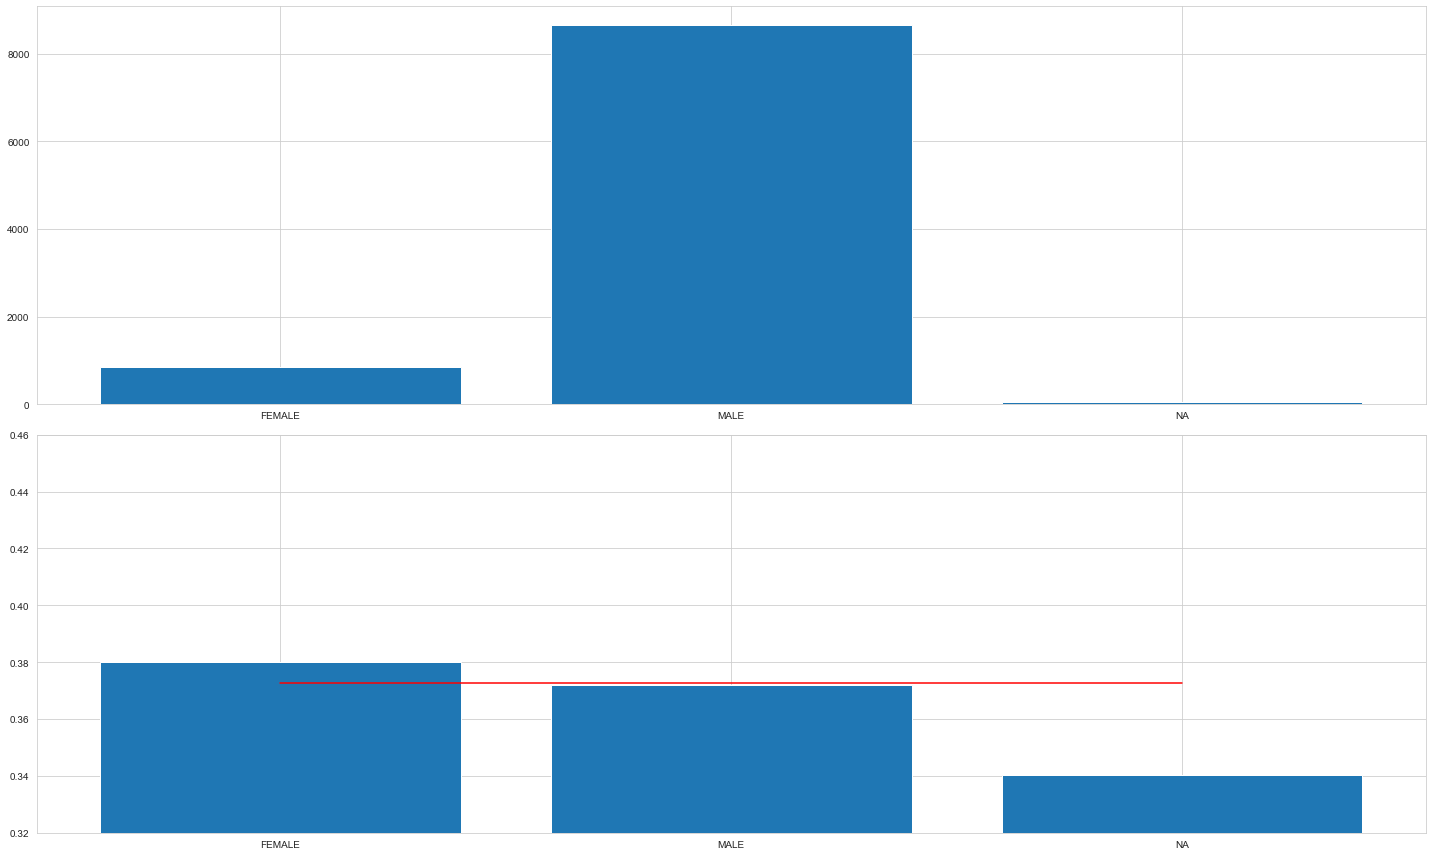

In [17]:
sex = stops2020['SUSPECT_SEX'].value_counts().sort_index()
sex_arrested = arrested['SUSPECT_SEX'].value_counts().sort_index()
sex_ratio = sex_arrested / sex

fig, axs = plt.subplots(2, figsize=(20,12))
axs[0].bar(sex.index ,height=sex)
plt.ylim(0.32,0.46)
axs[1].bar(sex_ratio.index ,height=sex_ratio)
axs[1].plot(sex_ratio.index, ratio_arrested[0:len(sex_ratio)], color='r')
plt.tight_layout()
plt.show()

# Hypothesis: there is no difference in arrested ratios between categories
## Random binomial comparison between categories 
### Using as bases for binomial test and chi-squared

In [18]:
ini, da, mo, lo, ra = 0, 2, 7, 3, 2
cof = .95
print(f'''index: {initiaded_arrested.index[ini]} n: {initiaded[ini]} 
observado: {initiaded_arrested[ini]} esperado: {stat.binom.interval(cof, initiaded[ini], ratio_arrested[0])}\n''')

print(f'''index: {day_week_arrested.index[da]} n: {day_week[da]} 
observado: {day_week_arrested[da]} esperado: {stat.binom.interval(cof, day_week[da], ratio_arrested[0])}\n''')

print(f'''index: {month_arrested.index[mo]} n: {month[mo]} 
observado: {month_arrested[mo]} esperado: {stat.binom.interval(cof, month[mo], ratio_arrested[0])}\n''')

print(f'''index: {location_arrested.index[lo]} n: {location[lo]} 
observado: {location_arrested[lo]} esperado: {stat.binom.interval(cof, location[lo], ratio_arrested[0])}\n''')

print(f'''index: {race_arrested.index[ra]} n: {race[ra]} 
observado: {race_arrested[ra]} esperado: {stat.binom.interval(cof, race[ra], ratio_arrested[0])}\n''')

index: Based on Radio Run n: 6424 
observado: 2454 esperado: (2318.0, 2470.0)

index: Saturday n: 1393 
observado: 527 esperado: (484.0, 555.0)

index: March n: 1155 
observado: 409 esperado: (398.0, 463.0)

index: QUEENS n: 1732 
observado: 721 esperado: (606.0, 685.0)

index: WHITE n: 5367 
observado: 345 esperado: (1931.0, 2070.0)



In [19]:
radio = stops2020[stops2020['STOP_WAS_INITIATED']=='Based on Radio Run']
notradio = stops2020[stops2020['STOP_WAS_INITIATED']!='Based on Radio Run']

radio_arrested = radio[radio[agged_variables['SUSPECT'][1]]=='Y']
notradio_arrested = notradio[notradio[agged_variables['SUSPECT'][1]]=='Y']

ratio_notradio_arrested = notradio_arrested.count() / notradio.count()[0]
ratio_radio_arrested = radio_arrested.count() / radio.count()[0]

print('Propotion Initiated Stop by ration %.4f vs not by radio %.4f\n' 
      % (ratio_radio_arrested[0], ratio_notradio_arrested[0]))

Propotion Initiated Stop by ration 0.3820 vs not by radio 0.3535



## Binomial test arrested by Initiatives
### Checking arrested 'success' when compared to how the stop was initiated

For this step, the data was grouped into 'radio' and 'not radio' categories, since the radio initiative is due to 911 calls or other requests and not dependent on the officer's self initiative.

In [20]:
alt = ['two-sided', 'greater', 'less']

p_radiovsnot = stat.binom_test(x= notradio_arrested.count()[0], 
                          n = notradio.count()[0], p= ratio_radio_arrested[0], alternative= alt[2])
print('P value: %.4f when comparison Stops initiated 911 vs not 911 '% (p_radiovsnot))

P value: 0.0005 when comparison Stops initiated 911 vs not 911 


# Calculating Chi-Squared on the variables 'days', 'months' and 'race' against 'radio initiave' situations only.

## Suggested analyses:
- Chi-Squared of race by demographic
- Chi-Squared of days using day and nught shift
- Chi-Squared of month by Season

> https://en.wikipedia.org/wiki/Demographics_of_New_York_City
> https://worldpopulationreview.com/states/new-york-population


In [21]:
initiaded_expected = initiaded * ratio_arrested[0]
exp = initiaded_expected.tolist()
obs = initiaded_arrested.tolist()

chi_gof = stat.chisquare(f_obs=obs, f_exp=exp)

print(f'Stops by location\n{initiaded}\n\nArrested by location\n{initiaded_expected}\n\nWith Chi-Squared GOF P-value: {chi_gof.pvalue}')

Stops by location
Based on Radio Run         6424
Based on Self Initiated    1781
Based on C/W on Scene      1339
Name: STOP_WAS_INITIATED, dtype: int64

Arrested by location
Based on Radio Run         2394.191953
Based on Self Initiated     663.769593
Based on C/W on Scene       499.038453
Name: STOP_WAS_INITIATED, dtype: float64

With Chi-Squared GOF P-value: 0.05992094622005481


In [22]:
location_expected = location * ratio_arrested[0]
exp = location_expected.tolist()
obs = location_arrested.tolist()

chi_gof = stat.chisquare(f_obs=obs, f_exp=exp)

print(f'Stops by location\n{location}\n\nArrested by location\n{location_arrested}\n\nWith Chi-Squared GOF P-value: {chi_gof.pvalue}')

Stops by location
BRONX            2044
BROOKLYN         2950
MANHATTAN        2453
QUEENS           1732
STATEN ISLAND     365
Name: STOP_LOCATION_BORO_NAME, dtype: int64

Arrested by location
BRONX            748
BROOKLYN         954
MANHATTAN        982
QUEENS           721
STATEN ISLAND    152
Name: STOP_LOCATION_BORO_NAME, dtype: int64

With Chi-Squared GOF P-value: 4.1870041844711184e-07


In [23]:
race_expected = race * ratio_arrested[0]
exp = race_expected.tolist()
obs = race_arrested.tolist()

chi_gof = stat.chisquare(f_obs=obs, f_exp=exp)

print(f'Stops by race\n{race}\n\nArrested by race\n{race_arrested}\n\nWith Chi-Squared GOF P-value: {chi_gof.pvalue}')

Stops by race
AMERICAN INDIAN/ALASKAN N      17
ASIAN / PACIFIC ISLANDER      219
BLACK                        5367
BLACK HISPANIC                829
MIDDLE EASTERN/SOUTHWEST      132
NA                             74
WHITE                         856
WHITE HISPANIC               2050
Name: SUSPECT_RACE_DESCRIPTION, dtype: int64

Arrested by race
BLACK                        1981
WHITE HISPANIC                783
WHITE                         345
BLACK HISPANIC                308
ASIAN / PACIFIC ISLANDER       73
MIDDLE EASTERN/SOUTHWEST       34
NA                             26
AMERICAN INDIAN/ALASKAN N       7
Name: SUSPECT_RACE_DESCRIPTION, dtype: int64

With Chi-Squared GOF P-value: 0.0


In [24]:
season_expected = season * ratio_arrested[0]
exp = season_expected.tolist()
obs = season_arrested.tolist()

chi_gof = stat.chisquare(f_obs=obs, f_exp=exp)

print(f'Stops by season\n{season}\n\nArrested by season\n{season_arrested}\n\nWith Chi-Squared GOF P-value: {chi_gof.pvalue}')

Stops by season
autumn    2042
spring    3162
summer    1467
winter    2873
Name: SEASON, dtype: int64

Arrested by season
autumn     816
spring    1199
summer     529
winter    1013
Name: SEASON, dtype: int64

With Chi-Squared GOF P-value: 0.04565478131245106


In [25]:
month_expected = month * ratio_arrested[0]
exp = month_expected.tolist()
obs = month_arrested.tolist()

chi_gof = stat.chisquare(f_obs=obs, f_exp=exp)

print(f'Stops by month\n{month}\n\nArrested by month\n{month_arrested}\n\nWith Chi-Squared GOF P-value: {chi_gof.pvalue}')

Stops by month
April         938
August        526
December      634
February     1097
January      1142
July          388
June          553
March        1155
May          1069
November      721
October       693
September     628
Name: MONTH2, dtype: int64

Arrested by month
April        344
August       199
December     244
February     389
January      380
July         143
June         187
March        409
May          446
November     255
October      276
September    285
Name: MONTH2, dtype: int64

With Chi-Squared GOF P-value: 0.00348974155605914


In [26]:
day_week_expected = day_week * ratio_arrested[0]
exp = day_week_expected.tolist()
obs = day_week_arrested.tolist()

chi_gof = stat.chisquare(f_obs=obs, f_exp=exp)

print(f'Stops by day\n{day_week}\n\nArrested by day\n{day_week_arrested}\n\nWith Chi-Squared GOF P-value: {chi_gof.pvalue}')

Stops by day
Friday       1302
Monday       1028
Saturday     1393
Sunday       1220
Thursday     1492
Tuesday      1533
Wednesday    1576
Name: DAY2, dtype: int64

Arrested by day
Friday       455
Monday       403
Saturday     527
Sunday       422
Thursday     569
Tuesday      609
Wednesday    572
Name: DAY2, dtype: int64

With Chi-Squared GOF P-value: 0.19926815325037814


# Continuous variables

In [27]:
stops2020_filtered = radio[(radio['STOP_LOCATION_BORO_NAME'] == 'BROOKLYN') | (
    radio['STOP_LOCATION_BORO_NAME'] == 'STATEN ISLAND') ]

stops2020_filtered = stops2020_filtered[(stops2020_filtered['SEASON'] == 'autumn') | (
    stops2020_filtered['SEASON'] == 'winter') ]

#stops2020_filtered = stops2020_filtered.set_index(['STOP_LOCATION_BORO_NAME', 'SEASON'])
columns_to_keep = ['STOP_FRISK_DATE', 'STOP_DURATION_MINUTES', 'STOP_LOCATION_STREET_NAME', 'TIME_HOUR',
                   'WEAPON_FOUND_FLAG', 'SUSPECT_HEIGHT', 'SUSPECTED_CRIME_DESCRIPTION', 'SUSPECT_ARRESTED_FLAG',
                   'PHYSICAL_FORCE_VERBAL_INSTRUCTION_FLAG', 'STOP_LOCATION_BORO_NAME', 'SEASON', 'DAY_PERIOD']
#stops2020_filtered[columns_to_keep].to_excel('FStops.xlsx') para grafico no miinitab não encontrei dotplot na lirary do matplotlib

#crime_filter = stops2020_filtered.groupby(by=['STOP_LOCATION_BORO_NAME', 'SUSPECTED_CRIME_DESCRIPTION'])['STOP_DURATION_MINUTES'].describe()
#crime_filter.loc['BROOKLYN']
#crime_filter.loc['STATEN ISLAND']

stat.normaltest(stops2020_filtered[(stops2020_filtered['STOP_LOCATION_BORO_NAME'] == 'STATEN ISLAND') & (
    stops2020_filtered['SUSPECTED_CRIME_DESCRIPTION'] == 'PETIT LARCENY')]['STOP_DURATION_MINUTES'])

NormaltestResult(statistic=4.287231142897413, pvalue=0.11723022161762708)

## Key findings
- Season and geographic region are relevant factors. When isolated, they produce a normal distribution curve;
- The duration of certain crimes in Staten Island are normally distributed;
- No evident pattern was found in Brooklyn.


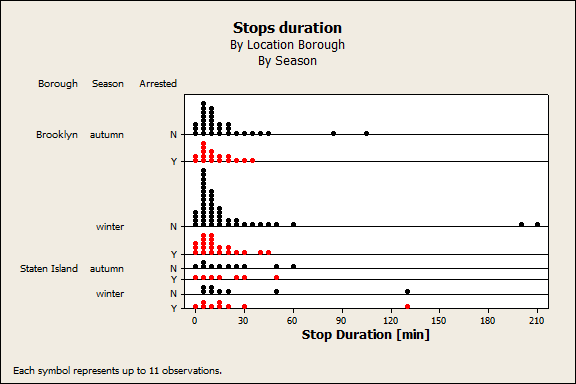

In [28]:
#notradio_day = notradio.groupby(by=['STOP_LOCATION_BORO_NAME', 'SEASON'])['STOP_DURATION_MINUTES'].count()
#notradio_day.unstack().plot(kind='hist', figsize=(10,7))

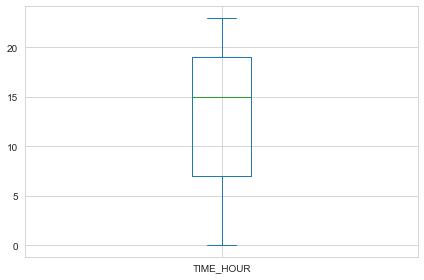

In [29]:
radio.plot(kind='box', x='STOP_DURATION_MINUTES', y='TIME_HOUR')
plt.tight_layout()
plt.show()

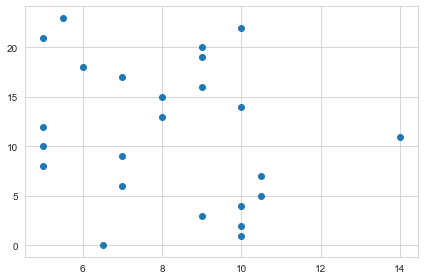

In [30]:
# Avg duration of Stops per day
group = [ 'TIME_HOUR']
med_duration_day = stops2020_filtered.groupby(by='TIME_HOUR')['STOP_DURATION_MINUTES'].median()
mean_duration_day = stops2020_filtered.groupby(by='TIME_HOUR')['STOP_DURATION_MINUTES'].mean()
count_count_day = stops2020_filtered.groupby(by='TIME_HOUR')['STOP_DURATION_MINUTES'].count()
#plt.scatter(x=mean_duration_day, y=mean_duration_day.index)
plt.scatter(x=med_duration_day, y=med_duration_day.index)
plt.tight_layout()
plt.show()

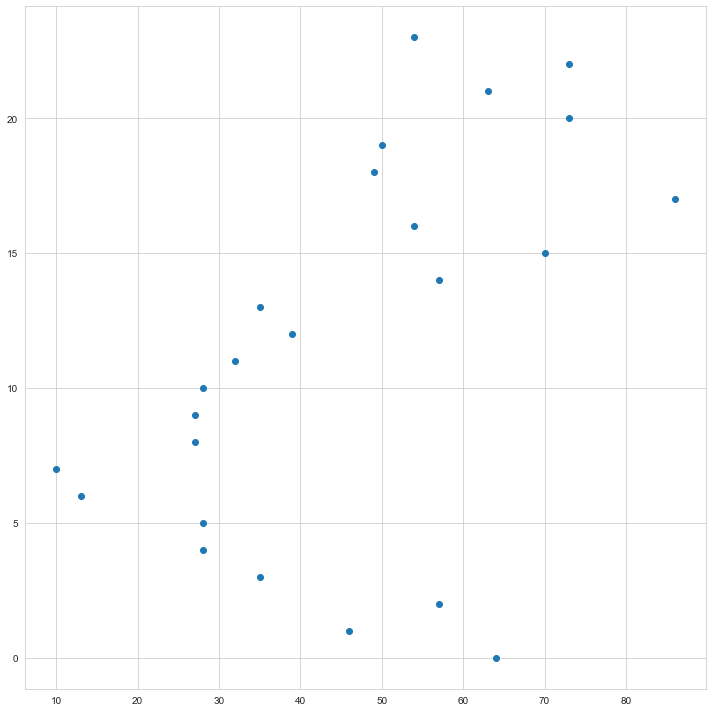

In [31]:
plt.figure(figsize=(10,10))
plt.scatter(x=count_count_day, y=count_count_day.index)
plt.tight_layout()
plt.show()

# Conclusion

The results showed that the NYPD officers are indeed profiling the citizens. However, a deeper look into the conversion rate of stops into actual arrests by race did not indicate possible inconsistencies in the data's behavior, making it not possible to claim the police are racially biased in this particular scenario. 

This project demonstrated the importance of using correct statistical analyses when exploring data, making inferences and drawing conclusions from it. Also, it served as a great example of how data can be used to address social issues, help tailor public policies and enhance safety of the general population.  
 

The subject at hand is a complex matter and a lot more time and much deeper analyses are required in order to reach further conclusions. Other questions that could be addressed in future studies are:  
> <i> 
- 'What is the justification for the high number of arrests within the targeted share of the population?'  
- 'Are there locations that require an increase in police activity?  
- 'What could be done to increase the efficiency of the program as a whole?</i>




%%shell
jupyter nbconvert --to html /content/Stats_project_Daniel.ipynb